## **COVID-19 Outcome Prediction Based on Mobility Measures in Virginia**

#### Presented by Anna Brower (aeb2de) and Claire Dozier (ced9mq)

In [ ]:
# load necessary modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf

# Load the Drive helper and mount
from google.colab import drive

pd.options.display.max_columns = None

In [ ]:
# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)

!ls '/content/drive/My Drive/CS4774_FinalProject/Data/'

Mounted at /content/drive
 2020_US_Region_Mobility_Report.csv
'coronanet_release_United States of America.csv'
 Excess_Deaths_Associated_with_COVID-19.csv
'New York'
'Old Data'
 Region_Mobility_Report_CSVs.zip
 time_series_covid19_confirmed_US.csv
 time_series_covid19_deaths_US.csv
 virginia-history.csv


In [ ]:
path = '/content/drive/My Drive/CS4774_FinalProject/Data/'

### **1. Data Cleaning and Preparation**

For this project, we utilized data from the following sources:

*   **COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (JHU)**: utilized time series data for confirmed COVID-19 cases and confirmed 
deaths from COVID-19 in the state of Virginia (used to calculate the mortality rate)
https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series
*  **The COVID Tracking Project**: utilized time series data for the number of tests conducted and the number of positive tests (used to calculate the infection rate)
https://covidtracking.com/data/state/virginia
* **Google COVID-19 Community Mobility Reports**: utilized time series data of percent change in mobility trends over time by geography across different categories of places (retail, recreation, groceries and pharmacies, parks, transit stations, workplaces, residential); the data is aggregated and anonymized (the same type of data used in Google Maps) 
https://www.google.com/covid19/mobility/

The "training" data for the VAR model goes till November 20, 2020, so the "testing" data used for forecasting purposes goes from November 21, 2020, to December 4, 2020 (the two-week period after the training data ends). 

### **2. Outcome Measures Used in Study**

The two chosen metrics to be modeled and predicted were: 

*   $ Mortality~ Rate = \frac{Number~of~Deaths}{Number~of~Confirmed~Cases}$

* $ Infection~Rate = \frac{Number~of~Positive~Tests}{Number~of~Tests~Conducted}$

Using the time series data from JHU, we extracted the number of deaths and cases per day (had to make the data not cumulative) and used the above equation to create a data frame containing the mortality rate per day from March 15, 2020, to November 20, 2020. 

For the time series testing data from The COVID Tracking Project, the data was already non-cumulative so we simply used the above equation to calculate the infection rate per day during the same time period. 

In [ ]:
## Calculate Mortality Rate 

# Read in the death and confirmed cases data from JHU
deaths = pd.read_csv(path + 'time_series_covid19_deaths_US.csv') 
confirmed_cases = pd.read_csv(path + 'time_series_covid19_confirmed_US.csv') 

# Extract just Virginia data 
deaths = deaths[deaths['Province_State'] == 'Virginia']
deaths = deaths.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
      'Country_Region', 'Lat', 'Long_', 'Combined_Key', 'Population'])

confirmed_cases = confirmed_cases[confirmed_cases['Province_State'] == 'Virginia']
confirmed_cases = confirmed_cases.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
      'Country_Region', 'Lat', 'Long_', 'Combined_Key'])
dates = list(confirmed_cases.columns)

# Make confirmed cases data non-cumulative 
confirmed_cases = confirmed_cases.sum(axis=0)
for x in range(len(confirmed_cases) - 1, 0, -1):
    confirmed_cases[x] = confirmed_cases[x] - confirmed_cases[x - 1]

# Make death data non-cumulative 
deaths = deaths.sum(axis=0)
for x in range(len(deaths) - 1, 0, -1):
    deaths[x] = deaths[x] - deaths[x - 1]

mortality_rate = deaths/confirmed_cases
mortality_rate = pd.DataFrame(data={'mortality_rate': mortality_rate, 'date': dates})

In [ ]:
## Calculate Infection Rate 

# Read in testing data from COVID Tracking Project 
total_tests = pd.read_csv(path + 'virginia-history.csv') 

# Use the infection rate formula to calculate infection rate 
infect_rate = total_tests['positiveIncrease']/total_tests['totalTestResultsIncrease']

# Create data frame with date and infection rate 
total_tests['infection_rate'] = infect_rate
total_tests = total_tests[['date', 'infection_rate']]
infect_rate = total_tests

In [ ]:
## Read in Virginia Google Mobility Data and Fix Scaling 

# Read in data 
mobility_data = pd.read_csv(path + '2020_US_Region_Mobility_Report.csv')

# Extract just Virginia data 
mobility_data = mobility_data[mobility_data['sub_region_1'] == 'Virginia']
mobility_data = mobility_data[mobility_data['iso_3166_2_code'] == 'US-VA']

# Reformat the date to be a datetime 
mobility_data['date'] = pd.to_datetime(mobility_data['date'], format='%Y-%m-%d')
mobility_data = mobility_data[['date', 'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline',
                             'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline',
                             'residential_percent_change_from_baseline']]

# Fix column names                             
mobility_data.columns = ['date', 'retail_and_recreation', 'grocery_and_pharmacy',
                             'parks', 'transit_stations', 'workplaces',
                             'residential']

# Make the percentages into decimals to be on the same scale as the mortality rate and infection rate data 
for col in ['retail_and_recreation', 'transit_stations', 'workplaces', 'grocery_and_pharmacy', 'parks', 'residential']:
  mobility_data[col] = mobility_data[col]/100

print(mobility_data)

             date  retail_and_recreation  grocery_and_pharmacy  parks  \
652793 2020-02-15                   0.02                  0.02   0.03   
652794 2020-02-16                   0.04                  0.00   0.09   
652795 2020-02-17                   0.08                  0.02   0.41   
652796 2020-02-18                   0.01                  0.02   0.22   
652797 2020-02-19                   0.02                  0.02   0.06   
...           ...                    ...                   ...    ...   
653079 2020-11-27                  -0.26                 -0.19   0.37   
653080 2020-11-28                  -0.25                 -0.13   0.39   
653081 2020-11-29                  -0.20                 -0.12   0.19   
653082 2020-11-30                  -0.19                 -0.11  -0.19   
653083 2020-12-01                  -0.15                 -0.02   0.02   

        transit_stations  workplaces  residential  
652793              0.04        0.00         0.00  
652794             

In [ ]:
## Combine the data 

# Reformat the dates for mortality and infection rate data 
infect_rate['date'] = pd.to_datetime(infect_rate['date'], format='%Y-%m-%d')
mortality_rate['date'] = pd.to_datetime(mortality_rate['date'], format='%m/%d/%y')

# Merge the mortality and infection rate data using an inner join on date
df = pd.merge(infect_rate, mortality_rate, how='inner', on='date')

# Create the "test" data data frame for the data after November 20th (Nov 21-Dec 4)
test_df = df[df['date'] >= datetime.datetime(2020, 11, 21)]


# Merge infection and mortality rate data frame with the Google Mobility data 
df = pd.merge(df, mobility_data, how='inner', on='date')
df = df.reindex(index=df.index[::-1])
test_df = test_df.reindex(index=test_df.index[::-1])
df = df[df['date'] > datetime.datetime(2020, 3, 14)]
df = df[df['date'] < datetime.datetime(2020, 11, 21)]


## Fix any missing values 
df = df.replace([np.inf, -np.inf], np.nan)
df.fillna(0, inplace=True)

test_df.fillna(0, inplace=True)

### **3. Data Visualization**

Following data cleaning and preparation, we visualized the infection and mortality rate time series, as well as the six different mobility categories. 

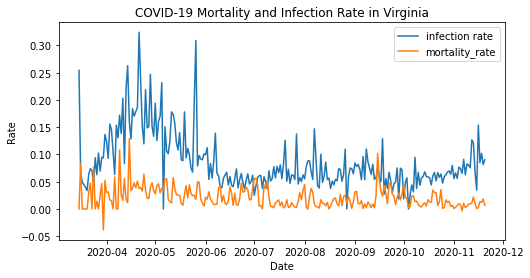

In [ ]:
## 1. Visualize infection rate and mortality rate 
f = plt.figure()
f.set_figheight(4)
f.set_figwidth(8)
plt.plot(df['date'], df['infection_rate'], label='infection rate')
plt.plot(df['date'], df['mortality_rate'], label = 'mortality_rate')
plt.title('COVID-19 Mortality and Infection Rate in Virginia')
plt.legend(loc="upper right")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.show()

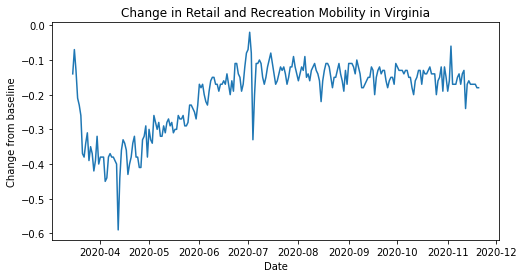

In [ ]:
## 2. Visualize Change in Retail and Recreation Mobility 
f = plt.figure()
f.set_figheight(4)
f.set_figwidth(8)
plt.plot(df['date'], df['retail_and_recreation'])
plt.title('Change in Retail and Recreation Mobility in Virginia')
plt.xlabel("Date")
plt.ylabel("Change from baseline")
plt.show()

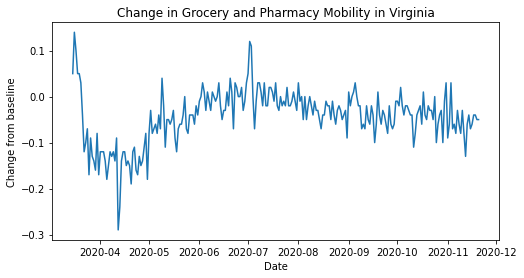

In [ ]:
## 3. Visualize Change in Grocery and Pharmacy Mobility
f = plt.figure()
f.set_figheight(4)
f.set_figwidth(8)
plt.plot(df['date'], df['grocery_and_pharmacy'])
plt.title('Change in Grocery and Pharmacy Mobility in Virginia')
plt.xlabel("Date")
plt.ylabel("Change from baseline")
plt.show()

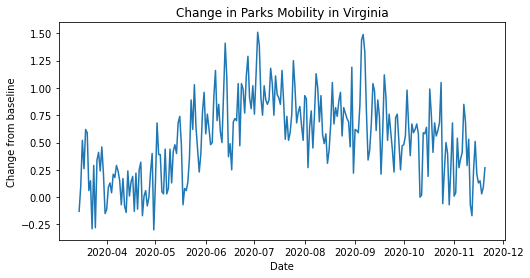

In [ ]:
## 4. Visualize Change in Parks Mobility
f = plt.figure()
f.set_figheight(4)
f.set_figwidth(8)
plt.plot(df['date'], df['parks'])
plt.title('Change in Parks Mobility in Virginia')
plt.xlabel("Date")
plt.ylabel("Change from baseline")
plt.show()

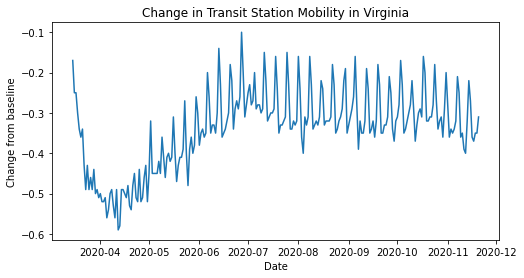

In [ ]:
## 5. Visualize Change in Transit Station Mobility
f = plt.figure()
f.set_figheight(4)
f.set_figwidth(8)
plt.plot(df['date'], df['transit_stations'])
plt.title('Change in Transit Station Mobility in Virginia')
plt.xlabel("Date")
plt.ylabel("Change from baseline")
plt.show()

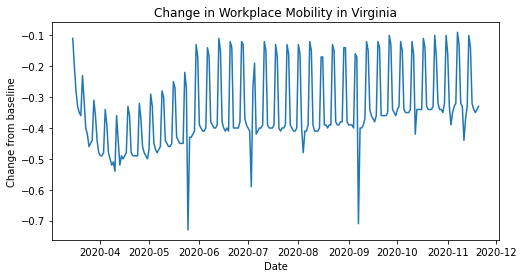

In [ ]:
## 6. Visualize Change in Workplace Mobility
f = plt.figure()
f.set_figheight(4)
f.set_figwidth(8)
plt.plot(df['date'], df['workplaces'])
plt.title('Change in Workplace Mobility in Virginia')
plt.xlabel("Date")
plt.ylabel("Change from baseline")
plt.show()

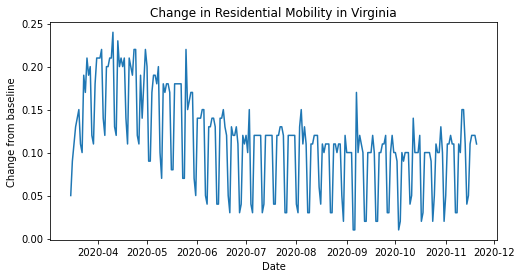

In [ ]:
## 7. Visualize Change in Residential Mobility
f = plt.figure()
f.set_figheight(4)
f.set_figwidth(8)
plt.plot(df['date'], df['residential'])
plt.title('Change in Residential Mobility in Virginia')
plt.xlabel("Date")
plt.ylabel("Change from baseline")
plt.show()

Based on the above visualized data, it is clear that following Governor Northam's March 30th stay-at-home order announcement, mobility measures changed significantly from their respective baselines. We chose to use the Google Community Mobility Reports as our indicator of policy effectiveness, specifically policies that relate to social distancing (which include business closures, limitations on the number of people allowed to gather, requiring people to work from home). 

Our visualizations also demonstrated that Retail and Recreation, Groceries and pharmacies, Transit Station, and Workplace mobility all declined significantly in the month of April (when social restrictions were in full force). When retrictions began to be lifted in May and July, the mobility increased and has remained fairly level in these sectors, though still below the pre-pandemic baseline. 

Notably, Parks and Residental saw positive changes from the baseline following these restrictions but the changes have since declined during the reopening phases. 

Used in combination with the infection and moratality rate data, the mobility data is an accessible numeric tracking measure of the efficacy of COVID-19 policies that seek to minimize population movement and interaction. 

### **4. Building a Vector Autoregression (VAR) Model to Predict Mortality and Infection Rate Using Mobility Data as Indicator of Policy Efficacy**

**Note: We utilized some methods, code, and textual explanations from this online tutorial for building VAR models: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/**

For our purposes, we are interested in simultaneously modeling and analyzing multiple time series. Vector Autoregression models are appropriate for this task because they can model multivariate time series data. 

From the tsa.vector_ar module: 

> We are interested in modeling a T×K multivariate time series Y, where T denotes the number of observations and K the number of variables. One way of estimating relationships between the time series and their lagged values is the vector autoregression process:

> $ Y_t = v + A_1Y_{t-1} + ... + A_pY_{t-p} + u_p $, where $ u_t~is~appx.~ Normal(0, \sum_u) $ and $ A_i $ is a K x K coefficient matrix

Source: https://www.statsmodels.org/stable/vector_ar.html#

In this project, there are T = 251 time observations in the "training" data and K = 8 different time series variables to be modeled.

The detailed modeling and analysis processes are discussed below.

#### **4.1 Check for Time Series Stationarity**

To check whether our different time series are stationary (i.e. the properties of the series do not depend on the time at which the series is observed), we implemented and analyzed the results of the Augmented Dickey-Fuller (ADF) Test (a type of unit root test). 

The ADF Test is one of the most widely used unit root tests and can determine how strongly a time series is defined by a trend. It uses an autoregressive model anbd optimizes the information criterion across multiple lag values. 

The null and alternate hypotheses are as follows: 

> $ H_0 $: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary (i.e. it has some time dependent structure)

> $ H_1$: The null hypothesis is rejected, which suggests the time series does not have a unit root, meaning it ios stationary (i.e. does not have a time-dependent structure)

We will fail to reject $H_0$ if p-value > 0.05, and reject the $H_0$ if p-value <= 0.05.

*Source: https://machinelearningmastery.com/time-series-data-stationary-python/*

In [ ]:
df.set_index('date', inplace=True)
test_df.set_index('date', inplace=True)

In [ ]:
## Method to run the ADF test and output report of results 

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

# ADF Test on each column
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "infection_rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.9781
 No. Lags Chosen       = 15
 Critical value 1%     = -3.458
 Critical value 5%     = -2.874
 Critical value 10%    = -2.573
 => P-Value = 0.2963. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "mortality_rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6678
 No. Lags Chosen       = 12
 Critical value 1%     = -3.458
 Critical value 5%     = -2.874
 Critical value 10%    = -2.573
 => P-Value = 0.0798. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "retail_and_recreation" 
    -------------------------------------------

After running the ADF Test for the first time, we observed that none of the eight different time series were stationary. The VAR class in the statsmodels package assumes that the time series are stationary for modeling. 

As a result, we chose to transform the data to make it stationary by taking first-differences. 

In [ ]:
## Take first differences of all time series in the data frme, and store as 
## df_differenced for use in future modeling

df_differenced = df.diff().dropna()

for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "infection_rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.5608
 No. Lags Chosen       = 14
 Critical value 1%     = -3.458
 Critical value 5%     = -2.874
 Critical value 10%    = -2.573
 => P-Value = 0.0066. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "mortality_rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.4803
 No. Lags Chosen       = 13
 Critical value 1%     = -3.458
 Critical value 5%     = -2.874
 Critical value 10%    = -2.573
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "retail_and_recreation" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-

After differencing once, we found that all of the time series became stationary and we could proceed in building the model. 

### **4.2 Test Causation Using the Granger Causality Test on the Stationary Data Prior to Building the Model**

From the MachineLearningPlus tutorial: 

> "The basis behind Vector AutoRegression is that each of the time series in the system influences each other. That is, you can predict the series with past values of itself along with other series in the system."

To test this relationship prior to building the model, we conducted the Granger Causality Test using the stattools module in the statsmodels packag for all possible combinations of the different time series data. 

Granger Causality tests the following: 

> $H_0$: The past values of the time series (X) **do not** Granger-cause the other series (Y).

> $H_1$: The past values of the time series (X) **do** Granger-cause the other series (Y). 

Thus, for a p-value < 0.05, we reject the null hypothesis and conclude a Granger-causal relationship exists. 







In [ ]:
## Method to carry out the Granger Causality Test for all combinations of 
## the time series variables and output a matrix of p-values 

maxlag=20
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],15) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [ ]:
## Conduct the Granger Causality Test using the above method and the eight 
## different time series 

grangers_causation_matrix(df_differenced, variables = df_differenced.columns)  

,infection_rate_x,mortality_rate_x,retail_and_recreation_x,grocery_and_pharmacy_x,parks_x,transit_stations_x,workplaces_x,residential_x
infection_rate_y,1.000000,0.013998,6.443142e-05,1.331770e-07,0.101593,2.693364e-06,4.050320e-10,3.427000e-12
mortality_rate_y,0.065810,1.000000,3.085126e-08,1.374721e-04,0.003800,3.270815e-06,3.181488e-08,5.807210e-10
retail_and_recreation_y,0.064486,0.000341,9.999998e-01,2.300900e-06,0.000609,2.643564e-07,5.526968e-09,7.940116e-09
grocery_and_pharmacy_y,0.079691,0.036034,1.799000e-12,1.000000e+00,0.000009,5.841785e-07,8.669450e-10,2.800000e-14
parks_y,0.006087,0.008301,5.179552e-04,2.045811e-06,1.000000,3.646900e-07,7.997685e-08,8.950008e-07
transit_stations_y,0.006079,0.000794,0.000000e+00,7.702524e-08,0.000117,1.000000e+00,4.700000e-14,0.000000e+00
workplaces_y,0.001250,0.000281,2.814102e-05,2.968906e-07,0.000097,0.000000e+00,1.000000e+00,9.666420e-10
residential_y,0.000099,0.000018,0.000000e+00,0.000000e+00,0.008327,0.000000e+00,8.678959e-09,1.000000e+00


By observing the above matrix of p-values, we can conclude that almost all of the variables (time series) in the system are interchangeably Granger-causing one other. 

This makes this system of multiple time series appropriate for using a VAR model to forecast. 

### **4.3 Selecting the Order (p) of the VAR Model**

In order to select the right order (p) of the VAR model, we iteratively fit increasing orders of VAR models and use the Akaike Information Criterion (AIC) metric to choose the best order model (i.e. the model order with the lowest AIC). 

Other model-selection metrics were printed for reference and convenience. 


In [ ]:
## Iteratively create different order VAR models 

# Declare instance of VAR
model = VAR(df_differenced)

# Iterate and fit models and print results
for i in [1,2,3,4,5,6,7,8,9,10]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -52.008546881947424
BIC :  -50.99145206851185
FPE :  2.588716767945276e-23
HQIC:  -51.59914949091318 

Lag Order = 2
AIC :  -53.08333571882643
BIC :  -51.156616728994024
FPE :  8.850104290588633e-24
HQIC:  -52.307711588994216 

Lag Order = 3
AIC :  -53.83261876571636
BIC :  -50.991008776543914
FPE :  4.199593534684066e-24
HQIC:  -52.68856434091248 

Lag Order = 4
AIC :  -54.13694279440751
BIC :  -50.375123585114245
FPE :  3.120879655442439e-24
HQIC:  -52.622233151169844 

Lag Order = 5
AIC :  -55.548649592155854
BIC :  -50.86125084497761
FPE :  7.701393204115712e-25
HQIC:  -53.66103815726308 

Lag Order = 6
AIC :  -56.71969422315171
BIC :  -51.10129281202493
FPE :  2.4331890208502293e-25
HQIC:  -54.456912486465114 

Lag Order = 7
AIC :  -56.8118387897965
BIC :  -50.25695805661424
FPE :  2.279573861952717e-25
HQIC:  -54.17159601232189 

Lag Order = 8
AIC :  -56.86669347620239
BIC :  -49.369802494378106
FPE :  2.238928285938323e-25
HQIC:  -53.84667639327737 

Lag Ord

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In the above output, the AIC drops to the lowest at lag 8, and then increases again. So we chose to go with a lag 8 VAR model (p = 8). 

### **4.4 Train the VAR Model of Selected Order (p=8)** 

Next, to do the actual estimation we called the *fit* method with the chosen lag order (p=8). 

The coefficients of the respective models for the different time series are provided by the model_fitted.summary() below. The two variables that we were focused on forecasting using the model are infection_rate and mortality_rate.

In [ ]:
model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 06, Dec, 2020
Time:                     22:10:02
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -49.3698
Nobs:                     242.000    HQIC:                  -53.8467
Log likelihood:           4653.80    FPE:                2.23893e-25
AIC:                     -56.8667    Det(Omega_mle):     3.33777e-26
--------------------------------------------------------------------
Results for equation infection_rate
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                            0.001048         0.002021            0.519           0.604
L1.infection_rate               -0.821455         0.073002          -11.253           0.000
L1.mort

### **4.5 Check for Serial Correlation in Model Residuals Using the Durbin Watson Test**

Serial correlation of residuals refers to any patterns that might remain in the residuals (errors) of the model following model training and fitting. If there is correlation remaining in the residuals, this might suggest that there patterns that were not accounted for. 

Thus, we used the Durbin Watson statistic as a measure of any remaining serial correlation in residuals. 

The basics of this statistic are as follows: 

> "The Durbin Watson (DW) statistic is a test for autocorrelation in the residuals from a statistical regression analysis. The Durbin-Watson statistic will always have a value between 0 and 4. A value of 2.0 means that there is no autocorrelation detected in the sample. Values from 0 to less than 2 indicate positive autocorrelation and values from from 2 to 4 indicate negative autocorrelation." 

*Source: https://www.investopedia.com/terms/d/durbin-watson-statistic.asp*


In [ ]:
## Call the durbin_watson method on the residuals of the fitted VAR model
out = durbin_watson(model_fitted.resid)

def adjust(val, length= 6): return str(val).ljust(length)

# Print the Durbin Watson statistics for each of the respective time series variables
for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

infection_rate : 1.97
mortality_rate : 1.96
retail_and_recreation : 2.0
grocery_and_pharmacy : 1.93
parks  : 1.96
transit_stations : 1.99
workplaces : 2.04
residential : 2.0


We can observe from the above output of the results that the Durbin Watson statistics for each of the time series variables are very close to the desired 2.0 value, which suggests that the serial correlation is fine and there are likely not significant patterns remaining in the residuals of the fitted model.

### **5. Forecasting Using the VAR Model**




In order to generate a forecast, the VAR model requires up to the chosen lag order number of observations from the past data (in our case, 8 lags).

According to the MachineLearningPlus tutorial, this is because:

> "The terms in the VAR model are essentially the lags of the various time series in the dataset, so you need to provide it as many of the previous values as indicated by the lag order used by the model."

Once the forecast input array is generated, this can be passed to the forecast function and the next 14 steps can be forecast (in our case, this is the next two-weeks of infection rates and mortality rates). 

Importantly, following the forecast generation, additional steps must be taken to invert the differencing transformation to get the real forecast. 

These steps are carried out below:


In [ ]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input


8


array([[-0.00591956,  0.01068549,  0.07      ,  0.07      ,  0.42      ,
         0.08      ,  0.04      , -0.04      ],
       [-0.05408972, -0.01275369,  0.01      ,  0.02      ,  0.26      ,
         0.1       ,  0.23      , -0.07      ],
       [-0.03243114, -0.00824733, -0.01      , -0.03      , -0.3       ,
        -0.05      , -0.04      ,  0.01      ],
       [ 0.11947066,  0.00137999,  0.        ,  0.01      , -0.08      ,
        -0.09      , -0.18      ,  0.06      ],
       [-0.06896747,  0.01140574,  0.        ,  0.02      ,  0.02      ,
        -0.01      , -0.02      ,  0.01      ],
       [ 0.0172371 , -0.0015756 ,  0.        ,  0.        , -0.12      ,
         0.02      , -0.01      ,  0.        ],
       [-0.02084394,  0.00635228, -0.01      , -0.01      ,  0.06      ,
         0.        ,  0.01      ,  0.        ],
       [ 0.00899399, -0.01213444,  0.        ,  0.        ,  0.18      ,
         0.04      ,  0.01      , -0.01      ]])

In [ ]:
## Using the fitted model and the forecast_input, generated a forecast for the next 14 steps (days) of data 
fc = model_fitted.forecast(y=forecast_input, steps=14)
df_forecast = pd.DataFrame(fc, index=test_df.index[-14:], columns=df.columns + '_1d')

# output the df_forecast matrix 
df_forecast



,infection_rate_1d,mortality_rate_1d,retail_and_recreation_1d,grocery_and_pharmacy_1d,parks_1d,transit_stations_1d,workplaces_1d,residential_1d
date,,,,,,,,
2020-11-21,-0.018189,-0.001939,-0.000813,0.024737,0.187073,0.074888,0.189814,-0.061066
2020-11-22,0.011036,0.009690,0.004489,-0.026386,-0.023931,-0.032220,-0.047555,0.010532
2020-11-23,0.012136,-0.009700,0.003355,-0.003241,-0.191014,-0.079033,-0.113921,0.036944
2020-11-24,-0.011727,0.010520,0.013990,0.010707,0.085220,-0.009203,-0.050700,0.019778
2020-11-25,0.013220,0.008325,-0.004465,-0.005724,-0.159452,0.013871,0.005270,-0.001304
2020-11-26,-0.011588,-0.011899,-0.002226,-0.005436,-0.051002,0.004705,0.013036,-0.000615
2020-11-27,0.004071,0.001514,-0.007115,0.008490,0.091755,0.027755,0.022020,-0.005709
2020-11-28,-0.004132,-0.001464,-0.014315,0.009909,0.177122,0.059163,0.147790,-0.049537
2020-11-29,-0.000851,-0.008877,0.014154,-0.012605,-0.030726,-0.021761,-0.010953,-0.003609


In [ ]:
## Invert the forecasts by rolling back the first-differences of the training data 
## This will provide the acutal forecast values 

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [ ]:
## Call the invert-transformation function, get the forecast for the date range from
## November 21, 2020, to December 4, 2020 

df_results = invert_transformation(df, df_forecast, second_diff=False)        
df_results.loc[:, ['infection_rate_forecast', 'mortality_rate_forecast', 'retail_and_recreation_forecast',
       'grocery_and_pharmacy_forecast',
       'workplaces_forecast', 'residential_forecast']]

,infection_rate_forecast,mortality_rate_forecast,retail_and_recreation_forecast,grocery_and_pharmacy_forecast,workplaces_forecast,residential_forecast
date,,,,,,
2020-11-21,0.072117,0.004350,-0.180813,-0.025263,-0.140186,0.048934
2020-11-22,0.083153,0.014040,-0.176324,-0.051649,-0.187741,0.059466
2020-11-23,0.095289,0.004340,-0.172969,-0.054890,-0.301662,0.096410
2020-11-24,0.083562,0.014860,-0.158979,-0.044184,-0.352362,0.116187
2020-11-25,0.096782,0.023185,-0.163444,-0.049908,-0.347092,0.114883
2020-11-26,0.085194,0.011286,-0.165670,-0.055344,-0.334056,0.114268
2020-11-27,0.089265,0.012801,-0.172785,-0.046853,-0.312036,0.108558
2020-11-28,0.085134,0.011336,-0.187100,-0.036944,-0.164246,0.059021
2020-11-29,0.084283,0.002460,-0.172946,-0.049549,-0.175199,0.055412


### **6. Experimental Results and Analysis**

Following generation of the forecasts for infection and mortality rate, we visualized our forecasts, calculated statistical performance metrics, and conducted the Ljung-Box Test for model adequacy up till a certain number of lags. 


### **6.1 Visualize Forecasts and Conduct Visual Analysis of Results**

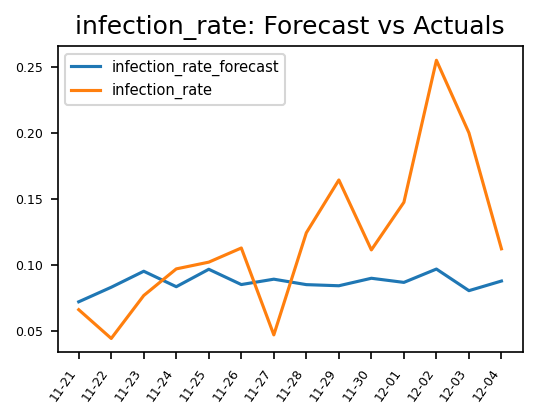

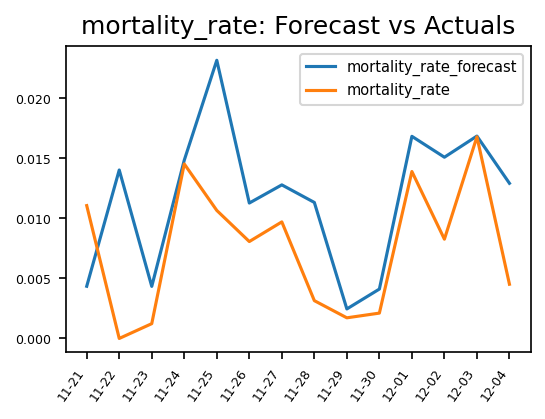

In [ ]:
## We are primarily interested in the forecast for the infection rate and 
## mortality rate over the two-week "testing time period"

## The forecast plots are outputted below 

nobs=14
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
for col in df[['infection_rate', 'mortality_rate']]:
    fig, ax = plt.subplots(1, 1, dpi=150, figsize=(4, 3))
    plt.plot(list(df_results.index), df_results[col + '_forecast'], label=col+'_forecast')
    plt.plot(list(test_df.index), test_df[col], label=col)
    ax.set_title(col + ": Forecast vs Actuals")

    ax.tick_params(labelsize=6)
    myFmt = mdates.DateFormatter('%m-%d')
    ax.xaxis.set_major_formatter(myFmt)
    fig.autofmt_xdate()
    plt.xticks(list(df_results.index))
    plt.xticks(rotation=55)
    plt.legend(fontsize=7)
    plt.show()

Based on our visualizations, it appears the the forecast for the infection rate is quite steady and does not fluctuate to the degree the actual infection rate fluctuates. There might be a few causes for this, including potentially:

*   Weaker Granger-causal relationship between infection rate and the other time series data 
*   There might be additional predictors that are needed to more accurately forecast the infection rate (mobility data and mortality rate may not be sufficient) or other confounding variables
* Infection rates are highly dependent on the number of tests conducted per day, and this can vary widely, making infection rate a more difficult metric to forecast

However, the model appears to perform better at forecasting the mortality rate, with the forecast closely following the patterns of the actual mortality rate. The model does appear to slightly over-estimate the mortality on each day (making it more conservative). 

Part of the visual analysis includes conducting the Ljung-Box Test, which determines whether the first H sample autocorrelations of the residuals, considered together are significant. We do not want significance in this test as that would imply autocorrelation. This test is similar to the Durbin Watson statistic evaluation but is an effective means of testing the adequacy of the model up to a certain number of lags. 

The Ljung-Box Hypotheis can be defined in the following way: 

> $H_0$: Autocorrelation is not significant (i.e. the model is adequate up to lag H)



> $H_1$: Autocorrelation is significant (i.e. the model is not adequate up to lag H)

The below graphs display the p-values for the different lags of the residuals from the fitted model. The orange-dashed line indicates the significance level of p=0.05. If points fall below that line, then the model is not adequate for that lag. The higher the points are, the higher the p-value and the stronger the evidence to accept the null hypothesis.

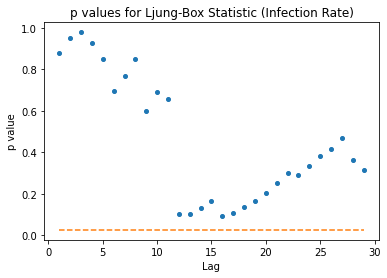

In [ ]:
## Conduct Ljung-Box Test and plot the p-values for the infection rate metric

pvals = []
for x in range(1, 30):
  pvals.append(sm.stats.acorr_ljungbox(model_fitted.resid['infection_rate'], lags=[x])[1])

plt.plot(range(1, 30), pvals, '.', markersize=8)
plt.plot(range(1,30), [0.025] * 29, linestyle='dashed')
plt.title("p values for Ljung-Box Statistic (Infection Rate)")
plt.xlabel("Lag")
plt.ylabel("p value")
plt.show()

For the infection rate p-values, it appears that they are quite high (above p=0.5) until lag 11. Following lag 11, there is a signficant dip in p-values but they rise fairly steadily up until lag 30 (they remain under appx. p=0.5). This visual analysis suggests that the model is fairly adequate at least until lag 11, and likely slightly beyond. This analysis is supported by the visualization of the forecast. For the first 11 days in the forecast (November 21, 2020, to December 1, 2020), the forecast is fairly close to the actual infection rate. The large deviation in the forecast begins after day 11. 

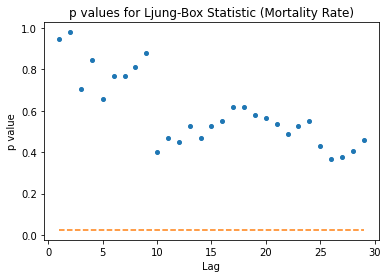

In [ ]:
## Conduct Ljung-Box Test and plot the p-values for the mortality rate metric
pvals = []
for x in range(1, 30):
  pvals.append(sm.stats.acorr_ljungbox(model_fitted.resid['mortality_rate'], lags=[x])[1])

plt.plot(range(1, 30), pvals, '.', markersize=8)
plt.plot(range(1,30), [0.025] * 29, linestyle='dashed')
plt.title("p values for Ljung-Box Statistic (Mortality Rate)")
plt.xlabel("Lag")
plt.ylabel("p value")
plt.show()

For the mortality rate p-values, the p-values are well above p=0.6 up until lag 9 and they remain fairly high for all subsequent lags, never dipping far below p=0.4 up until at least lag 30. This suggests that the model is very adequate at forecasting the mortality rate. This is confirmed through the visual evaluation of the mortality rate forecast above, in which the forecast closely mirrors the actual mortality rate for the entire 14-day testing period. 

### **6.2 Metric Analysis of Results**



Following our visual analysis, we computed three statistical metrics to evaluate how well our forecasts predicted the actual data: 

*   Mean Squared Error: $ MSE = \frac{1}{n} \sum_{i=1}^n (Y_i - \hat Y_i)^2 $
*   Root Mean Squared Error (or Deviation): $ RMSE = \sqrt{\frac {\sum_{i=1}^N (x_i- \hat x_i)^2}{N}} $
* Correlation: $ \rho_{X, Y} = corr(X,Y) = \frac{cov(X,Y)}{\sigma_{x} \sigma_{Y}} $

Notes about these measures: 

*   MSE and RMSE is are simple measures of the imperfection of the fit of the estimator of the data 
* Correlation refers to the existence of a statistical relationship between the forecasted and actual data values (but correlation does not equal causation)




In [ ]:
def forecast_accuracy(forecast, actual):
    mse = np.mean((forecast - actual)**2)       # MSE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mse': mse, 'rmse':rmse, 'corr':corr})
    
print('Forecast Accuracy of: infection rate')
accuracy_prod = forecast_accuracy(df_results['infection_rate_forecast'].values, test_df['infection_rate'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,10))

print('Forecast Accuracy of: mortality rate')
accuracy_prod = forecast_accuracy(df_results['mortality_rate_forecast'].values, test_df['mortality_rate'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,10))

Forecast Accuracy of: infection rate
mse    :  0.0040523103
rmse   :  0.0636577592
corr   :  0.2264818128
Forecast Accuracy of: mortality rate
mse    :  4.47247e-05
rmse   :  0.0066876498
corr   :  0.5593556241


For the infection rate forecast, the MSE and RMSE were both quite small (under 0.1), which suggests that the model did an adequate job of estimating the infection rate. However, the correlation coefficient is only about 0.23, which might indicate that there are other variables that are predictive and are missing in the model (as discussed earlier). It should be noted that because real data is used, there is likely noise and the data is not perfect. 

For the mortality rate forecast, the MSE and RMSE were both incredibly low (less than 0.05), which suggests that the VAR model provided a fairly accurate forecast of the mortality rate. Additionally, the correlation coefficient is much higher for the mortality rate than the infection rate, indicating that there seems to be evidence of moderately signficant correlation between the selected variables and the mortality rate. 